In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from chart_studio import plotly as py
import matplotlib.pyplot as plt
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
from pylab import mpl 
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体 
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# 定义绘图函数

In [2]:
def plot_anomaly(ts,anomaly_pred = None,anomaly_true=None,file_name = 'file'):
    fig = go.Figure()
    yhat = go.Scatter(
    x = ts.index,
    y = ts,
    mode = 'lines',  name = ts.name)
    fig.add_trace(yhat)
    if  anomaly_pred is not None:
        status = go.Scatter(
        x = anomaly_pred.index,
        y = ts.loc[anomaly_pred.index],
        mode = 'markers',  name = anomaly_pred.name,marker= {'color':'red','size':10,'symbol':'star','line_width':0})
        fig.add_trace(status)
    if  anomaly_true is not None:
        status = go.Scatter(
        x = anomaly_true.index,
        y = ts.loc[anomaly_true.index],
        mode = 'markers',  name = anomaly_true.name,marker= {'color':'yellow','size':10,'symbol':'star-open','line_width':2})
        fig.add_trace(status)   
    fig.show()
    
def plot_anomaly_window(ts,anomaly_pred = None,file_name = 'file',window='1h'):
    fig = go.Figure()
    yhat = go.Scatter(
    x = ts.index,
    y = ts,
    mode = 'lines',  name = ts.name)
    fig.add_trace(yhat)
    if  anomaly_pred is not None:
        for i in anomaly_pred.index:
            fig.add_vrect(x0=i - pd.Timedelta(window),x1= i,line_width=0, fillcolor="red", opacity=0.2) 
    fig.show()

# 导入数据

In [3]:
import pandas as pd 
df = pd.read_csv("C:/Users/Genius/Desktop/泰迪杯/全部数据/附件2-行业日负荷数据.csv")
df.head()

,行业类型,数据时间,有功功率最大值（kw）,有功功率最小值（kw）
0,大工业用电,2019/1/1,117888.3300,51526.5690
1,大工业用电,2019/1/2,126843.7914,63638.4294
2,大工业用电,2019/1/3,130286.1294,102048.2754
3,大工业用电,2019/1/4,133018.6344,104466.0762
4,大工业用电,2019/1/5,133504.4784,99507.3528


In [4]:
metrics_df=pd.pivot_table(df,values='有功功率最大值（kw）',index='数据时间',columns='行业类型')
metrics_df.head()

行业类型,商业,大工业用电,普通工业,非普工业
数据时间,,,,
2019/1/1,64027.8582,117888.3300,6179.9364,NaN
2019/1/10,144992.7153,123156.6018,9690.6846,NaN
2019/1/11,143797.0083,123400.7388,8421.3138,NaN
2019/1/12,102870.5328,113420.7912,6113.1345,NaN
2019/1/13,124603.7418,99806.6688,5908.7964,NaN


In [5]:
metrics_df.reset_index(inplace=True)
# metrics_df.fillna(0,inplace=True)
metrics_df.head()
metrics_df = metrics_df.rename(columns={'数据时间':'Time'})

In [6]:
metrics_df.head()

行业类型,Time,商业,大工业用电,普通工业,非普工业
0,2019/1/1,64027.8582,117888.3300,6179.9364,NaN
1,2019/1/10,144992.7153,123156.6018,9690.6846,NaN
2,2019/1/11,143797.0083,123400.7388,8421.3138,NaN
3,2019/1/12,102870.5328,113420.7912,6113.1345,NaN
4,2019/1/13,124603.7418,99806.6688,5908.7964,NaN


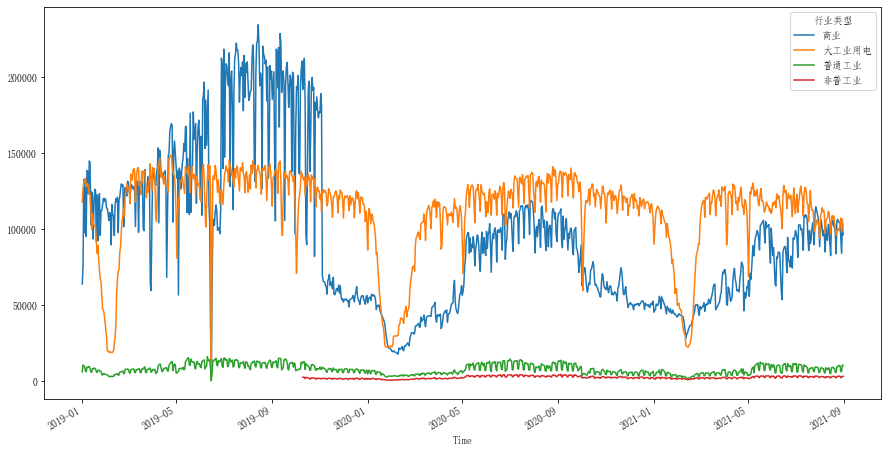

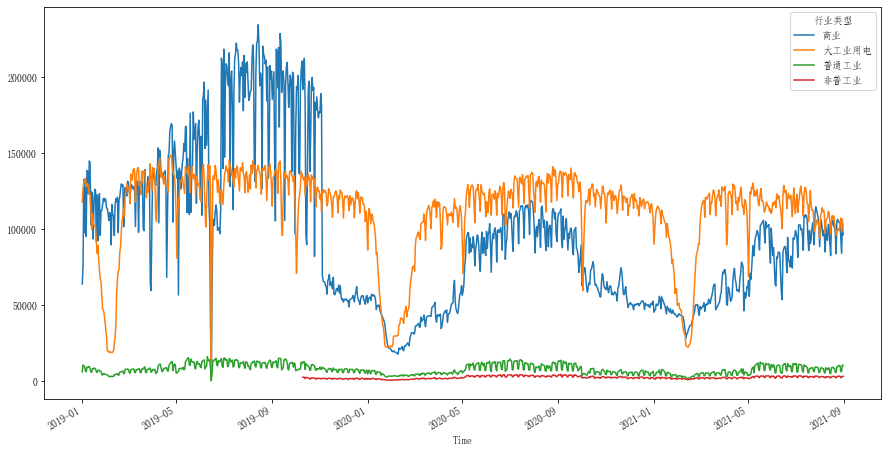

In [7]:
df = metrics_df
df['Time']= pd.to_datetime(df['Time'])
df.set_index('Time',inplace=True)
col = df.columns[0]
df.plot(figsize=(15, 8))
ax = df.plot(figsize=(15, 8))
fig = ax.get_figure()
fig.savefig('two.png')

# 跟据3西格玛原则(quantile(0.03),quantile(0.97)自己调整)

In [8]:
df.columns[1]

'大工业用电'

In [21]:
col = df.columns[1]
min_t = df[col].quantile(0.03)
max_t = df[col].quantile(0.97)
df[col+'threshold_alarm'] = (df[col].clip(lower = min_t,upper=max_t) != df[col])
plot_anomaly(df[col],anomaly_pred = df[df[col+'threshold_alarm']==True][col+'threshold_alarm'],anomaly_true=None,file_name = 'file')

# 差分(变化量级)

In [10]:
df[col+'突变量级'] = df[col].diff()

In [11]:
df[col+'突变量级']

Time
2019-01-01           NaN
2019-01-10     5268.2718
2019-01-11      244.1370
2019-01-12    -9979.9476
2019-01-13   -13614.1224
                 ...    
2021-08-05    -2427.2376
2021-08-06      949.0494
2021-08-07    -3494.9898
2021-08-08   -11662.8930
2021-08-09     7918.9056
Name: 大工业用电突变量级, Length: 973, dtype: float64

In [12]:
a = pd.DataFrame(df[df[col]>df[col].quantile(0.97)][[col,col+'突变量级']])
b = pd.DataFrame(df[df[col]<df[col].quantile(0.03)][[col,col+'突变量级']])
pd.concat([a,b])

行业类型,大工业用电,大工业用电突变量级
Time,,
2019-03-29,143142.1248,8744.3070
2019-04-10,146660.7108,6035.9550
2019-04-22,146709.6726,22332.5568
2019-04-23,148031.6940,1322.0214
2019-04-24,148863.5724,831.8784
2019-04-25,148364.3184,-499.2540
2019-04-26,141903.2406,-6461.0778
2019-04-08,142263.7932,18766.6020
2019-04-09,143186.1756,922.3824


In [13]:
pd.concat([a,b]).to_csv('大工业用电突变.csv',index=0)

In [14]:
df.columns[2]

'普通工业'

In [15]:
col = df.columns[2]
print(col)
min_t = df[col].quantile(0.03)
max_t = df[col].quantile(0.97)
df[col+'threshold_alarm'] = (df[col].clip(lower = min_t,upper=max_t) != df[col])
plot_anomaly(df[col],anomaly_pred = df[df[col+'threshold_alarm']==True][col+'threshold_alarm'],anomaly_true=None,file_name = 'file')
df[col+'突变量级'] = df[col].diff()
a = pd.DataFrame(df[df[col]>df[col].quantile(0.97)][[col,col+'突变量级']])
b = pd.DataFrame(df[df[col]<df[col].quantile(0.03)][[col,col+'突变量级']])
pd.concat([a,b]).to_csv(col+'突变.csv',index=0)

普通工业


In [16]:
col = df.columns[0]
print(col)
min_t = df[col].quantile(0.03)
max_t = df[col].quantile(0.97)
df[col+'threshold_alarm'] = (df[col].clip(lower = min_t,upper=max_t) != df[col])
plot_anomaly(df[col],anomaly_pred = df[df[col+'threshold_alarm']==True][col+'threshold_alarm'],anomaly_true=None,file_name = 'file')
df[col+'突变量级'] = df[col].diff()
a = pd.DataFrame(df[df[col]>df[col].quantile(0.97)][[col,col+'突变量级']])
b = pd.DataFrame(df[df[col]<df[col].quantile(0.03)][[col,col+'突变量级']])
pd.concat([a,b]).to_csv(col+'突变.csv',index=0)

商业


In [17]:
a = metrics_df.copy()

a.reset_index(inplace=True)
# metrics_df.fillna(0,inplace=True)
a = a.rename(columns={'数据时间':'Time'})
# a['Time']= pd.to_datetime(df['Time'])
a.set_index('Time',inplace=True)
a.dropna(axis=0, how='any', inplace=True)

a.head()

行业类型,商业,大工业用电,普通工业,非普工业,大工业用电threshold_alarm,大工业用电突变量级,普通工业threshold_alarm,普通工业突变量级,商业threshold_alarm,商业突变量级
Time,,,,,,,,,,
2019-10-10,192039.9429,134245.0128,12185.0820,2621.3316,False,37824.2808,False,5261.3403,False,25339.6206
2019-10-11,209020.6644,132520.7700,12883.6179,2669.0172,False,-1724.2428,False,698.5359,False,16980.7215
2019-10-12,212524.3536,134475.2892,12892.7982,2632.9704,False,1954.5192,False,9.1803,True,3503.6892
2019-10-13,183299.3544,122049.2202,7772.6058,1810.2156,False,-12426.0690,False,-5120.1924,False,-29224.9992
2019-10-14,96388.2387,134237.6268,11615.3631,2522.4576,False,12188.4066,False,3842.7573,False,-86911.1157


# 非普工业

In [18]:
col = a.columns[4]
print(col)
min_t = a[col].quantile(0.03)
max_t = a[col].quantile(0.97)
a[col+'threshold_alarm'] = (a[col].clip(lower = min_t,upper=max_t) != a[col])
plot_anomaly(a[col],anomaly_pred = a[a[col+'threshold_alarm']==True][col+'threshold_alarm'],anomaly_true=None,file_name = 'file')
a[col+'突变量级'] = a[col].diff()
c = pd.DataFrame(a[a[col]>a[col].quantile(0.97)][[col,col+'突变量级']])
b = pd.DataFrame(a[df[col]<a[col].quantile(0.03)][[col,col+'突变量级']])
pd.concat([c,b]).to_csv(col+'突变.csv',index=0)

大工业用电threshold_alarm


In [19]:
col = a["非普工业"]
print(col)

Time
2019-10-10    2621.3316
2019-10-11    2669.0172
2019-10-12    2632.9704
2019-10-13    1810.2156
2019-10-14    2522.4576
                ...    
2021-08-05    3003.1230
2021-08-06    3070.5174
2021-08-07    2526.8004
2021-08-08    2343.5808
2021-08-09    3124.7010
Name: 非普工业, Length: 691, dtype: float64


突变点位置： [259]


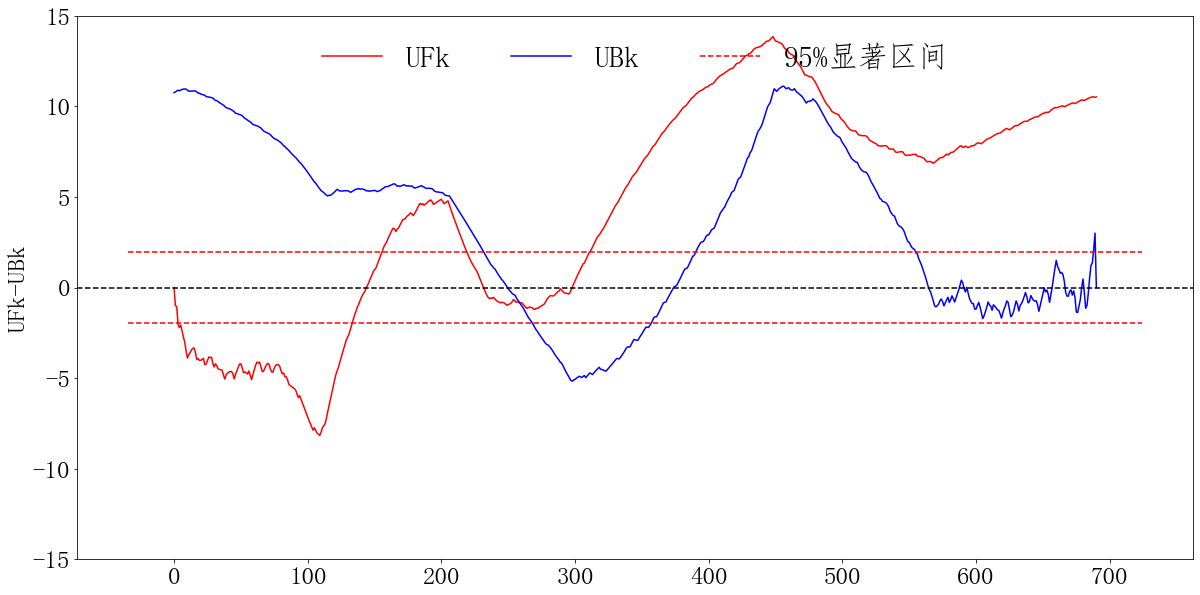

In [20]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt 
 
def sk(data):
    n=len(data)
    Sk     = [0]
    UFk    = [0]
    s      =  0
    E      = [0]
    Var    = [0]
    for i in range(1,n):
        for j in range(i):
            if data[i] > data[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        E.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UFk.append((Sk[i]-E[i])/np.sqrt(Var[i]))
    UFk=np.array(UFk)
    return UFk

#a为置信度
def MK(data,a):
    ufk=sk(data)          #顺序列
    ubk1=sk(data[::-1])   #逆序列
    ubk=-ubk1[::-1]        #逆转逆序列
    
    #输出突变点的位置
    p=[]
    u=ufk-ubk
    for i in range(1,len(ufk)):
        if u[i-1]*u[i]<0:
            p.append(i)            
    if p:
        print("突变点位置：",p)
    else:
        print("未检测到突变点")
    
    #画图
    conf_intveral = stats.norm.interval(a, loc=0, scale=1)   #获取置信区间

    plt.figure(figsize=(20,10))
    plt.plot(range(len(data)),ufk,label = 'UFk',color = 'r')
    plt.plot(range(len(data)),ubk,label = 'UBk',color = 'b')
    plt.ylabel('UFk-UBk',fontsize=25)
    x_lim = plt.xlim()
    plt.ylim([-15,15])
    plt.plot(x_lim,[conf_intveral[0],conf_intveral[0]],'m--',color='r',label='95%显著区间')
    plt.plot(x_lim,[conf_intveral[1],conf_intveral[1]],'m--',color='r')
    plt.axhline(0,ls="--",c="k")
    plt.legend(loc='upper center',frameon=False,ncol=3,fontsize=30) # 图例
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.show()

#输入数据和置信度即可
MK(col,0.95)